# Hate Detection Procedure

## Part 1: Preparing environment and data

### Readying dependencies

In [2]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import pickle
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

from nltk.corpus import stopwords
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\My
[nltk_data]     Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocessing

In [4]:
## Loading data
# ## Ethos data
# data = pd.read_csv("Ethos_Dataset_Binary.csv", delimiter=';')
# data.columns = ['text','label']
# data['label'] =  data['label'].astype(int)

## dyno data
data = pd.read_csv("Dynamically Generated Hate Dataset v0.2.3.csv")

data.head()

,Unnamed: 0,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
0,1,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
1,2,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
2,3,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN
3,4,acl1000,4,I'm not saying we should actually eliminate he...,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN
4,5,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN


In [5]:
## converting labels to nothate = 0 and hate = 1    
## dyna data
def convert_labels(label):
    if label == "hate": return 1
    elif label == "nothate": return 0
    else: raise Exception("WRONG LABEL")

data['label'] = data['label'].apply(lambda x: convert_labels(x))


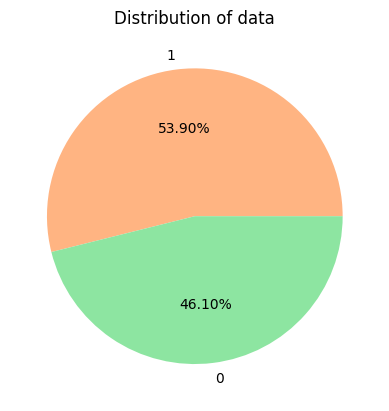

In [6]:
##  Visualizing distribution of data
colors = sns.color_palette('pastel')[1:3]
values = data['label'].value_counts().values
labels =  data['label'].value_counts().index
plt.pie(x=values, labels=labels, colors=colors, autopct='%.2f%%')
plt.title("Distribution of data")
plt.show()

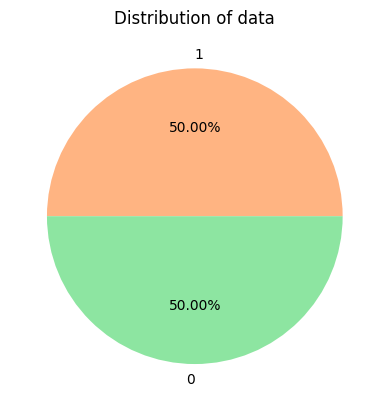

In [7]:
# Downsampling to balance the dataset

## dyna data
hate_msg = data[data.label == 1][['text','label']]
nothate_msg = data[data.label == 0][['text','label']]
hate_msg = hate_msg.sample(n=len(nothate_msg), random_state=42)

# ## ethos data
# hate_msg = data[data.label == 1][['text','label']]
# nothate_msg = data[data.label == 0][['text','label']]
# nothate_msg = nothate_msg.sample(n=len(hate_msg), random_state=42)

## Creating new balanced dataset
new_data = pd.concat([hate_msg, nothate_msg], ignore_index=True)

# Plotting the counts of down sampled dataset
##  Visualizing distribution of data
colors = sns.color_palette('pastel')[1:3]
values = new_data['label'].value_counts().values
labels = new_data['label'].value_counts().index

plt.pie(x=values, labels=labels, colors=colors, autopct='%.2f%%')
plt.title("Distribution of data")
plt.show()

In [8]:
hate_msg

,text,label
29131,"hello reddit, I'm a non-Arab and I hate almost...",1
27413,Tell me how many of my brothas fell victim to ...,1
21452,I would be accepting this Vaccine to assist in...,1
4688,basketball team is only for tall people and Ch...,1
38629,White races are higher quality stock than dark,1
...,...,...
5391,These daaaarkies should be removed from this w...,1
7227,Black barbies always complain dolls don't come...,1
11020,this trashy immigrant should be deported with ...,1
9399,Niggers are the lowest scum of earth. Every fu...,1


In [9]:
## Getting Texts
text_data = new_data['text']
text_data[:5]

0    hello reddit, I'm a non-Arab and I hate almost...
1    Tell me how many of my brothas fell victim to ...
2    I would be accepting this Vaccine to assist in...
3    basketball team is only for tall people and Ch...
4       White races are higher quality stock than dark
Name: text, dtype: object

In [10]:
## Getting labels
clean_label_data = new_data['label']
clean_label_data[:5]

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [162]:
## Function to remove stopwords from sentences
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    temp = ' '.join([word for word in text.split() if word not in stop_words])
    return temp

## Function to remove special characters from sentences
def remove_special(text):
    special_char = ['%','$','#','@','^','_','*','?',';',':','.',',',"'",'=','’']
    for char in special_char:
        text = text.replace(char,'')
    return text
    
clean_text_data = text_data.apply(lambda x: remove_special(x)).apply(lambda x: remove_stopwords(x))

In [272]:
## function to remove short datapoints
def remove_short(texts, labels, length = 2):
    temp_texts = []
    temp_labels = []
    for i,text in enumerate(texts):
        words = text.split(" ")
        num_words = len(words)
        if num_words >= length:
            temp_texts.append(text)
            temp_labels.append(labels[i])
        else:
            pass
    temp_texts = pd.Series(temp_texts)
    temp_labels = pd.Series(temp_labels)
    return temp_texts, temp_labels

long_clean_text_data, long_clean_label_data = remove_short(clean_text_data,clean_label_data)

In [273]:
long_clean_text_data[:5]

0    hello reddit Im non-Arab I hate almost everyth...
1    Tell many brothas fell victim streets Now rest...
2    I would accepting Vaccine assist depopulation ...
3    basketball team tall people Chinese short bett...
4                White races higher quality stock dark
dtype: object

In [274]:
## Longest word in data
longest_data = len(long_clean_text_data[long_clean_text_data.str.len().idxmax()].split(' '))
print("# of words in longest data point:", longest_data)

# of words in longest data point: 229


In [275]:
## Count of words per data point
num_words=[]
for i in long_clean_text_data:
    num_words.append(len(i.split(' ')))

## sorting number of words
num_words.sort()

In [276]:
## average length of words
np.average(num_words)

14.075211193241817

In [277]:
## median of length of words
np.median(num_words)

10.0

In [278]:
## Setting max len for inputs
max_len = 12

## Part 2: Machine Learning Development

### Creating Train and Test sets

In [279]:
## Splitting train and test data
train_X, test_X, train_y, test_y = train_test_split(long_clean_text_data,    # x data                                       
                                                    long_clean_label_data,   # y data
                                                    test_size=0.2,      #in percentage
                                                    random_state = 42   #for reproducibility
                                                    )

In [280]:
## Showing size of training and test data
print("Number of training data: ", len(train_X))
print("Number of test data: ", len(test_X))

Number of training data:  30304
Number of test data:  7576


In [281]:
## Showing training data
print("TRAIN X")
print(train_X[:5])
print("TRAIN Y")
print(train_y[:5])

TRAIN X
26281    I fear entered world thieves scum use disposal...
22232    You killing here!! Of course I think businessm...
37801                                going dads house shit
8170     I feel bad girl But kind dumb post rant Intern...
19139                                      That chair vile
dtype: object
TRAIN Y
26281    0
22232    0
37801    0
8170     1
19139    0
dtype: int64


In [282]:
## Showing test data
print("TEST X")
print(test_X[:5])
print("TEST Y")
print(test_y[:5])

TEST X
6892     Black people play minority oppression card get...
36955                                       laptop useless
8101                        gay people real threat society
35971                 I dont think fucking monkey types UK
34862    FDA warns contaminated hand sanitizers make go...
dtype: object
TEST Y
6892     1
36955    0
8101     1
35971    0
34862    0
dtype: int64


### Tokenizing data (similar to vectorizing)

In [312]:

# Tokenize the text data
tokenizer = Tokenizer(oov_token="<OOV>", lower=False)
tokenizer.fit_on_texts(train_X)

def text_tokenizer(text, tokenizer, max_len):
    tokenizer = tokenizer
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequences = pad_sequences(sequences,
                                        maxlen=max_len,
                                        padding='post', 
                                        truncating='post'
                                        )
    return padded_sequences

train_sequences = text_tokenizer(train_X, tokenizer, max_len)
test_sequences = text_tokenizer(test_X, tokenizer, max_len)

In [313]:
## displaying sample sequences
for i in range(5):
    print(train_sequences[i])

[    2   720  4392    44  2674   274   125 10815  1347   874  4142   190]
[  37  621 1727  826  322    2   12 4393  477   23  382 1168]
[  48 5378  262   23    0    0    0    0    0    0    0    0]
[   2   72  113  231   53  210  366  452 4681 4682  135  240]
[ 171 2305  793    0    0    0    0    0    0    0    0    0]


### Training Machine Learning

In [314]:
## Initializing logistic regression model
log_reg = LogisticRegression(random_state=42,
                                solver='liblinear',
                                # penalty='l2',
                                # C=1e-2,
                                # max_iter=50,
                                )

In [315]:
## Training model
log_reg.fit(train_sequences, train_y)

## Showing score of training
print(f'Train Accuracy: {100*log_reg.score(train_sequences, train_y):.2f}%')

Train Accuracy: 52.36%


In [316]:
## Showing score of testing
print(f'Train Accuracy: {100*log_reg.score(test_sequences, test_y):.2f}%')

Train Accuracy: 51.39%


<Axes: >

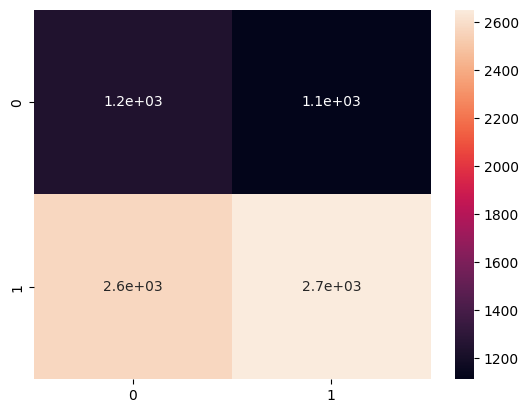

In [317]:
## Creating confusion matrix
y_predictions = log_reg.predict(test_sequences)
cf = confusion_matrix(y_predictions, test_y)
sns.heatmap(cf, annot=True)

### Training Neural Network


In [318]:
## Defining sequential model
model = Sequential()

## Adding layers to model architecture
model.add(layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32, 
                                    input_length=max_len))
# model.add(layers.Bidirectional(layers.LSTM(128,return_sequences=True)))
# model.add(layers.Bidirectional(layers.LSTM(16,return_sequences=True)))
# model.add(layers.Dropout(0.4))
model.add(layers.Bidirectional(layers.LSTM(8)))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [319]:
# Print the model summary
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 12, 32)            987392    
                                                                 
 bidirectional_46 (Bidirecti  (None, 16)               2624      
 onal)                                                           
                                                                 
 dropout_55 (Dropout)        (None, 16)                0         
                                                                 
 dense_50 (Dense)            (None, 128)               2176      
                                                                 
 dense_51 (Dense)            (None, 1)                 129       
                                                                 
Total params: 992,321
Trainable params: 992,321
Non-trainable params: 0
_______________________________________________

In [320]:
## Compiling model with loss and optimizer
model.compile(loss = 'binary_crossentropy',
              metrics = ['accuracy'],
              optimizer = Adam(1e-4))

In [321]:
## Defining callbacks
es = EarlyStopping(patience=5,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.1,
                       verbose = 0,
                       min_lr=1e-7)

# Train the model
history = model.fit(train_sequences, train_y,
                    validation_data=(test_sequences, test_y),
                    epochs=128, 
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/128
947/947 [==============================] - 10s 8ms/step - loss: 0.6908 - accuracy: 0.5469 - val_loss: 0.6815 - val_accuracy: 0.6015 - lr: 1.0000e-04
Epoch 2/128
947/947 [==============================] - 7s 7ms/step - loss: 0.6436 - accuracy: 0.6435 - val_loss: 0.6407 - val_accuracy: 0.6125 - lr: 1.0000e-04
Epoch 3/128
947/947 [==============================] - 7s 7ms/step - loss: 0.5777 - accuracy: 0.6942 - val_loss: 0.6366 - val_accuracy: 0.6056 - lr: 1.0000e-04
Epoch 4/128
947/947 [==============================] - 7s 7ms/step - loss: 0.5307 - accuracy: 0.7312 - val_loss: 0.6597 - val_accuracy: 0.6015 - lr: 1.0000e-04
Epoch 5/128
947/947 [==============================] - 7s 7ms/step - loss: 0.4928 - accuracy: 0.7556 - val_loss: 0.6902 - val_accuracy: 0.5952 - lr: 1.0000e-04
Epoch 6/128
947/947 [==============================] - 7s 7ms/step - loss: 0.4465 - accuracy: 0.7906 - val_loss: 0.7154 - val_accuracy: 0.5981 - lr: 1.0000e-05
Epoch 7/128
947/947 [==================

## Part 3: Evaluation and Saving

### Displaying Results

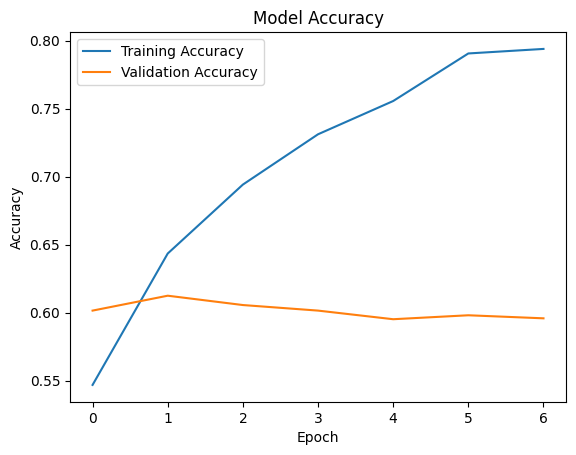

In [322]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

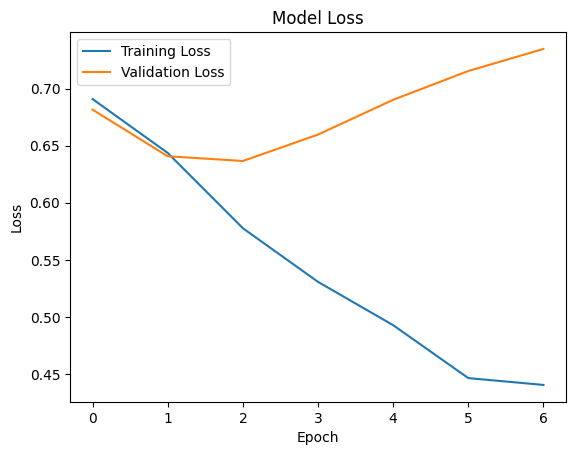

In [323]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Testing

In [324]:
test_labels = ['not hate','hate']

In [325]:
test_input = "I dont fucking know what to do with you just die already! You've been kinda useless to be honest."
true_y = 1 # hate

clean_test_input = remove_stopwords(test_input)
clean_test_input = remove_special(test_input)
sequence_clean_test_input = text_tokenizer([clean_test_input], tokenizer, max_len)

result = model.predict(sequence_clean_test_input)
round_result = int(result[0].round())

print("True answer",test_labels[true_y])
print("Predicted answer",test_labels[round_result], result[0][0])

1/1 [==============================] - 0s 442ms/step
True answer hate
Predicted answer not hate 0.26577395


In [326]:
test_input = "I hope it's allowed to be absent tomoorow. I don't know what to do at the next class honestly!"
true_y = 0 # not hate

clean_test_input = remove_stopwords(test_input)
clean_test_input = remove_special(test_input)
sequence_clean_test_input = text_tokenizer([clean_test_input], tokenizer, max_len)

result = model.predict(sequence_clean_test_input)
round_result = int(result[0].round())

print("True answer",test_labels[true_y])
print("Predicted answer",test_labels[round_result], result[0][0])

1/1 [==============================] - 0s 19ms/step
True answer not hate
Predicted answer not hate 0.49590313


### Saving Model